In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import os
import time  # Para medir o tempo
import itertools  # Para plotar a matriz de confusão
from tensorflow.keras.applications import (
    DenseNet201,
    ResNet152V2,
    NASNetLarge,
    VGG19,
    Xception,
    InceptionV3,
    InceptionResNetV2,
    MobileNetV2
)
import pandas as pd

2024-09-23 00:22:14.357798: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-23 00:22:14.488431: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-23 00:22:14.523106: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-23 00:22:14.769786: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-23 00:22:16.328191: W tensorflow/compiler/tf2

In [2]:
# Diretório dos dados
DATA_DIR = '../DATA/classification'

# Parâmetros de treinamento
BATCH_SIZE = 32
IMG_SIZE = (224, 224)  # Será ajustado conforme o modelo
EPOCHS = 30

NUM_CLASSES = 3  # benign, malignant, normal

In [3]:
datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
    validation_split=0.15  # 15% of data for validation
)


# Gerador para o conjunto de treinamento
train_generator = datagen.flow_from_directory(
    directory=DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    classes=['benign', 'malignant', 'normal'],
)

# Gerador para o conjunto de validação
validation_generator = datagen.flow_from_directory(
    directory=DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    classes=['benign', 'malignant', 'normal'],
)

# Obter os nomes das classes a partir do gerador
class_labels = list(train_generator.class_indices.keys())

Found 665 images belonging to 3 classes.
Found 115 images belonging to 3 classes.


In [4]:
def create_model(base_model, num_classes):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Camada de pooling global
    x = Dense(1024, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01))(x)  # L2 regularization
    x = Dropout(0.5)(x)  # Dropout layer
    x = Dense(512, activation='relu')(x)  # Add another dense layer
    predictions = Dense(num_classes, activation='softmax')(x)  # Camada de saída
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [5]:
models_to_evaluate = [
    ('MobileNetV2', MobileNetV2),
    ('InceptionResNetV2', InceptionResNetV2),
    ('VGG19', VGG19),
    ('Xception', Xception),
    ('InceptionV3', InceptionV3),
]

In [6]:
import os
import time
import numpy as np
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

def create_model(base_model, num_classes):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Camada de pooling global
    x = Dense(1024, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01))(x)  # L2 regularization
    x = Dropout(0.5)(x)  # Dropout layer
    x = Dense(512, activation='relu')(x)  # Add another dense layer
    predictions = Dense(num_classes, activation='softmax')(x)  # Camada de saída
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

results = []

# Diretório para salvar os modelos treinados
MODEL_DIR = '../saved_models'
os.makedirs(MODEL_DIR, exist_ok=True)

for model_name, model_function in models_to_evaluate:
    model_path = os.path.join(MODEL_DIR, f"{model_name}.h5")
    
    # Ajustar o tamanho da imagem conforme o requisito do modelo
    if model_name == 'NASNetLarge':
        IMG_SIZE = (331, 331)
    elif model_name in ['InceptionV3', 'Xception', 'InceptionResNetV2']:
        IMG_SIZE = (299, 299)
    else:
        IMG_SIZE = (224, 224)
    
    # Atualizar os geradores com o novo tamanho de imagem
    train_generator = datagen.flow_from_directory(
        directory=DATA_DIR,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training',
        shuffle=True,
        classes=['benign', 'malignant', 'normal'],
    )

    # Gerador para o conjunto de validação
    validation_generator = datagen.flow_from_directory(
        directory=DATA_DIR,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation',
        shuffle=False,
        classes=['benign', 'malignant', 'normal'],
    )
    
    # Obter os nomes das classes
    class_labels = list(train_generator.class_indices.keys())
    
    if os.path.exists(model_path):
        print(f"\nCarregando o modelo existente: {model_name}")
        model = keras.models.load_model(model_path)
        
        # Medir o tempo de teste e fazer previsões
        start_time = time.time()
        Y_pred = model.predict(validation_generator)
        testing_time = time.time() - start_time
        y_pred = np.argmax(Y_pred, axis=1)
        
        # Obter as classes verdadeiras
        y_true = validation_generator.classes
        
        # Relatório de classificação
        report = classification_report(y_true, y_pred, target_names=class_labels, output_dict=True)
        
        # Matriz de confusão
        cm = confusion_matrix(y_true, y_pred)
        
        # Cálculo das curvas ROC e AUC
        fpr = {}
        tpr = {}
        roc_auc = {}
        for i in range(NUM_CLASSES):
            fpr[i], tpr[i], _ = roc_curve(
                to_categorical(y_true, num_classes=NUM_CLASSES)[:, i],
                Y_pred[:, i]
            )
            roc_auc[i] = auc(fpr[i], tpr[i])
        
        # Adicionar os resultados
        results.append({
            'model_name': model_name,
            'history': None,  # Histórico não está disponível ao carregar o modelo
            'training_time': None,  # Tempo de treinamento não está disponível
            'testing_time': testing_time,
            'classification_report': report,
            'confusion_matrix': cm,
            'fpr': fpr,
            'tpr': tpr,
            'roc_auc': roc_auc
        })
        
        # Exibir as métricas
        print(f"Tempo de Teste: {testing_time:.2f} segundos")
        print("Relatório de Classificação:")
        print(classification_report(y_true, y_pred, target_names=class_labels))
        
    else:
        print(f"\nTreinando o modelo: {model_name}")
        
        # Carregar o modelo base pré-treinado
        base_model = model_function(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,))
        
        # Congelar as camadas do modelo base
        for layer in base_model.layers:
            layer.trainable = False
        
        # Descongelar as camadas superiores para fine-tuning
        fine_tune_at = int(len(base_model.layers) * 0.2)  # Descongelar as últimas 20% camadas
        for layer in base_model.layers[fine_tune_at:]:
            layer.trainable = True
        
        # Criar o modelo
        model = create_model(base_model, num_classes=NUM_CLASSES)
        
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
        
        # Medir o tempo de treinamento
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
    
        start_time = time.time()
        history = model.fit(
           train_generator,
           epochs=50,  # Aumentar épocas
           validation_data=validation_generator,
           callbacks=[early_stop, lr_reduce],
           verbose=True
        )
        training_time = time.time() - start_time
        
        # Salvar o modelo treinado
        model.save(model_path)
        print(f"Modelo {model_name} salvo em {model_path}")
        
        # Medir o tempo de teste e fazer previsões
        start_time = time.time()
        Y_pred = model.predict(validation_generator)
        testing_time = time.time() - start_time
        y_pred = np.argmax(Y_pred, axis=1)
        
        # Obter as classes verdadeiras
        y_true = validation_generator.classes
        
        # Relatório de classificação
        report = classification_report(y_true, y_pred, target_names=class_labels, output_dict=True)
        
        # Matriz de confusão
        cm = confusion_matrix(y_true, y_pred)
        
        # Cálculo das curvas ROC e AUC
        fpr = {}
        tpr = {}
        roc_auc = {}
        for i in range(NUM_CLASSES):
            fpr[i], tpr[i], _ = roc_curve(
                to_categorical(y_true, num_classes=NUM_CLASSES)[:, i],
                Y_pred[:, i]
            )
            roc_auc[i] = auc(fpr[i], tpr[i])
        
        # Salvar os resultados
        results.append({
            'model_name': model_name,
            'history': history,
            'training_time': training_time,
            'testing_time': testing_time,
            'classification_report': report,
            'confusion_matrix': cm,
            'fpr': fpr,
            'tpr': tpr,
            'roc_auc': roc_auc
        })
        
        # Exibir as métricas
        print(f"Tempo de Treinamento: {training_time:.2f} segundos")
        print(f"Tempo de Teste: {testing_time:.2f} segundos")
        print("Relatório de Classificação:")
        print(classification_report(y_true, y_pred, target_names=class_labels))

Found 665 images belonging to 3 classes.
Found 115 images belonging to 3 classes.

Treinando o modelo: MobileNetV2


I0000 00:00:1727061739.852090  333762 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727061740.116953  333762 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727061740.117172  333762 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727061740.123235  333762 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727061740.123411  333762 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Epoch 1/50


/home/tivo/TI0160-VisaoComputacionalAplicadaASaude-UFC-2024.1/env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1727061763.776789  337470 service.cc:146] XLA service 0x7f9f78017b50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727061763.776858  337470 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2024-09-23 00:22:44.285819: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-23 00:22:46.567178: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:53

10/21 ━━━━━━━━━━━━━━━━━━━━ 4s 412ms/step - accuracy: 0.2568 - loss: 12.6321

2024-09-23 00:23:23.369153: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6472', 28 bytes spill stores, 28 bytes spill loads

2024-09-23 00:23:23.579432: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6472', 160 bytes spill stores, 160 bytes spill loads

2024-09-23 00:23:23.618299: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6472', 176 bytes spill stores, 176 bytes spill loads

2024-09-23 00:23:24.995527: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_12848', 32 bytes spill stores, 32 bytes spill loads

2024-09-23 00:23:25.167970: I external/local_xla/xla/st

20/21 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - accuracy: 0.2999 - loss: 12.5772

2024-09-23 00:23:49.910479: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1202', 132 bytes spill stores, 132 bytes spill loads

2024-09-23 00:23:53.539277: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1195', 12 bytes spill stores, 12 bytes spill loads

2024-09-23 00:23:53.597071: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1195', 200 bytes spill stores, 200 bytes spill loads

2024-09-23 00:23:54.198241: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1202', 32 bytes spill stores, 32 bytes spill loads

2024-09-23 00:23:54.511488: I external/local_xla/xla/str

21/21 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.3070 - loss: 12.5689 - val_accuracy: 0.5739 - val_loss: 12.3181 - learning_rate: 1.0000e-05
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 361ms/step - accuracy: 0.5032 - loss: 12.3600 - val_accuracy: 0.5652 - val_loss: 12.3286 - learning_rate: 1.0000e-05
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 358ms/step - accuracy: 0.5423 - loss: 12.2766 - val_accuracy: 0.5652 - val_loss: 12.2765 - learning_rate: 1.0000e-05
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 365ms/step - accuracy: 0.5326 - loss: 12.1991 - val_accuracy: 0.5652 - val_loss: 12.2020 - learning_rate: 1.0000e-05
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 407ms/step - accuracy: 0.5862 - loss: 12.1717 - val_accuracy: 0.5478 - val_loss: 12.1747 - learning_rate: 1.0000e-05
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 373ms/step - accuracy: 0.5791 - loss: 12.0889 - val_accuracy: 0.5739 - val_loss: 12.1082 - learning_rate: 1.0000e-05
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 366ms/step - accur

Modelo MobileNetV2 salvo em ../saved_models/MobileNetV2.h5
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step  
Tempo de Treinamento: 637.06 segundos
Tempo de Teste: 7.72 segundos
Relatório de Classificação:
              precision    recall  f1-score   support

      benign       0.86      0.66      0.75        65
   malignant       0.40      0.81      0.54        31
      normal       1.00      0.16      0.27        19

    accuracy                           0.62       115
   macro avg       0.75      0.54      0.52       115
weighted avg       0.76      0.62      0.61       115

Found 665 images belonging to 3 classes.
Found 115 images belonging to 3 classes.

Treinando o modelo: InceptionResNetV2
219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step
Epoch 1/50


/home/tivo/TI0160-VisaoComputacionalAplicadaASaude-UFC-2024.1/env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-09-23 00:34:50.890579: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_46345', 144 bytes spill stores, 144 bytes spill loads

2024-09-23 00:34:51.602298: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_50834', 32 bytes spill stores, 32 bytes spill loads

2024-09-23 00:34:52.109488: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393]

19/21 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step - accuracy: 0.5208 - loss: 13.2722

2024-09-23 00:36:22.444990: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_46345', 28 bytes spill stores, 28 bytes spill loads

2024-09-23 00:36:22.504005: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_46345', 172 bytes spill stores, 172 bytes spill loads

2024-09-23 00:36:23.656597: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_50834', 32 bytes spill stores, 32 bytes spill loads

2024-09-23 00:36:23.991994: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_46345', 160 bytes spill stores, 160 bytes spill loads

2024-09-23 00:36:24.014675: I external/local_xla/xla

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5227 - loss: 13.2695 

2024-09-23 00:37:39.022611: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5404', 12 bytes spill stores, 12 bytes spill loads

2024-09-23 00:37:39.169371: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5404', 172 bytes spill stores, 172 bytes spill loads

2024-09-23 00:37:39.403388: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5404', 160 bytes spill stores, 160 bytes spill loads



21/21 ━━━━━━━━━━━━━━━━━━━━ 266s 6s/step - accuracy: 0.5237 - loss: 13.2681 - val_accuracy: 0.5652 - val_loss: 13.1632 - learning_rate: 1.0000e-05
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 22s 749ms/step - accuracy: 0.5829 - loss: 13.1380 - val_accuracy: 0.5652 - val_loss: 13.0881 - learning_rate: 1.0000e-05
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 713ms/step - accuracy: 0.5660 - loss: 13.0361 - val_accuracy: 0.5652 - val_loss: 12.9702 - learning_rate: 1.0000e-05
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 713ms/step - accuracy: 0.5711 - loss: 12.9398 - val_accuracy: 0.5652 - val_loss: 12.8195 - learning_rate: 1.0000e-05
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 695ms/step - accuracy: 0.5531 - loss: 12.8474 - val_accuracy: 0.5652 - val_loss: 12.7562 - learning_rate: 1.0000e-05
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 703ms/step - accuracy: 0.5692 - loss: 12.7244 - val_accuracy: 0.5652 - val_loss: 12.6616 - learning_rate: 1.0000e-05
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 703ms/step - accu

Modelo InceptionResNetV2 salvo em ../saved_models/InceptionResNetV2.h5
4/4 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step 
Tempo de Treinamento: 1223.92 segundos
Tempo de Teste: 24.86 segundos
Relatório de Classificação:
              precision    recall  f1-score   support

      benign       0.83      0.89      0.86        65
   malignant       0.78      0.58      0.67        31
      normal       0.73      0.84      0.78        19

    accuracy                           0.80       115
   macro avg       0.78      0.77      0.77       115
weighted avg       0.80      0.80      0.79       115

Found 665 images belonging to 3 classes.
Found 115 images belonging to 3 classes.

Carregando o modelo existente: VGG19


/home/tivo/TI0160-VisaoComputacionalAplicadaASaude-UFC-2024.1/env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7f9e28cf5c60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


4/4 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step 
Tempo de Teste: 25.31 segundos
Relatório de Classificação:
              precision    recall  f1-score   support

      benign       0.78      0.86      0.82        65
   malignant       0.59      0.42      0.49        31
      normal       0.71      0.79      0.75        19

    accuracy                           0.73       115
   macro avg       0.69      0.69      0.69       115
weighted avg       0.72      0.73      0.72       115

Found 665 images belonging to 3 classes.
Found 115 images belonging to 3 classes.

Carregando o modelo existente: Xception


/home/tivo/TI0160-VisaoComputacionalAplicadaASaude-UFC-2024.1/env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-09-23 00:54:50.548104: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1017', 176 bytes spill stores, 468 bytes spill loads

E0000 00:00:1727063699.382060  337470 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1727063699.511432  337470 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a mi

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step

2024-09-23 00:55:10.317275: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1017', 4 bytes spill stores, 4 bytes spill loads

2024-09-23 00:55:10.978720: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1017', 176 bytes spill stores, 176 bytes spill loads

2024-09-23 00:55:11.083459: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1017', 12 bytes spill stores, 12 bytes spill loads

2024-09-23 00:55:11.158282: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1017', 36 bytes spill stores, 36 bytes spill loads

E0000 00:00:1727063717.373235  337468 gpu_timer.cc:183] Dela

4/4 ━━━━━━━━━━━━━━━━━━━━ 36s 5s/step 
Tempo de Teste: 37.08 segundos
Relatório de Classificação:
              precision    recall  f1-score   support

      benign       0.79      0.89      0.84        65
   malignant       0.74      0.55      0.63        31
      normal       0.68      0.68      0.68        19

    accuracy                           0.77       115
   macro avg       0.74      0.71      0.72       115
weighted avg       0.76      0.77      0.76       115

Found 665 images belonging to 3 classes.
Found 115 images belonging to 3 classes.

Carregando o modelo existente: InceptionV3


/home/tivo/TI0160-VisaoComputacionalAplicadaASaude-UFC-2024.1/env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 4s/step 
Tempo de Teste: 27.58 segundos
Relatório de Classificação:
              precision    recall  f1-score   support

      benign       0.80      0.92      0.86        65
   malignant       0.80      0.52      0.63        31
      normal       0.75      0.79      0.77        19

    accuracy                           0.79       115
   macro avg       0.78      0.74      0.75       115
weighted avg       0.79      0.79      0.78       115



In [7]:
def plot_confusion_matrix(cm, classes,
                          model_name,
                          normalize=False,
                          title='Matriz de Confusão',
                          cmap=plt.cm.Blues):
    """
    Esta função imprime e plota a matriz de confusão.
    Normalização pode ser aplicada definindo `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de Confusão Normalizada")
    else:
        print('Matriz de Confusão Sem Normalização')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(f'{title} - {model_name}')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Classe Verdadeira')
    plt.xlabel('Classe Predita')
    plt.tight_layout()
    plt.show()

In [8]:
def plot_roc_curves(fpr, tpr, roc_auc, classes, model_name):
    plt.figure()
    for i in range(len(classes)):
        plt.plot(fpr[i], tpr[i],
                 label='Classe {0} (AUC = {1:0.2f})'
                       ''.format(classes[i], roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--')  # Linha diagonal
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falsos Positivos')
    plt.ylabel('Taxa de Verdadeiros Positivos')
    plt.title(f'Curvas ROC - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

In [9]:

def plot_training_history(history, model_name):
    """
    Plota a história de treinamento do modelo.
    
    Args:
    history: História de treinamento retornada pelo método fit do Keras.
    model_name: Nome do modelo.
    """
    # Plotar a acurácia de treinamento e validação
    plt.figure(figsize=(12, 4))
    
    # Acurácia
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Acurácia de Treinamento')
    plt.plot(history.history['val_accuracy'], label='Acurácia de Validação')
    plt.title(f'Acurácia - {model_name}')
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia')
    plt.legend()
    
    # Perda
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Perda de Treinamento')
    plt.plot(history.history['val_loss'], label='Perda de Validação')
    plt.title(f'Perda - {model_name}')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

Matriz de Confusão Normalizada


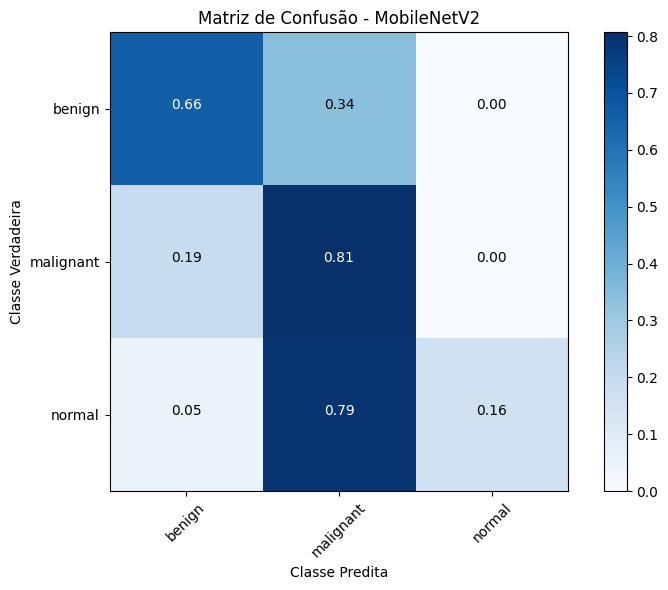

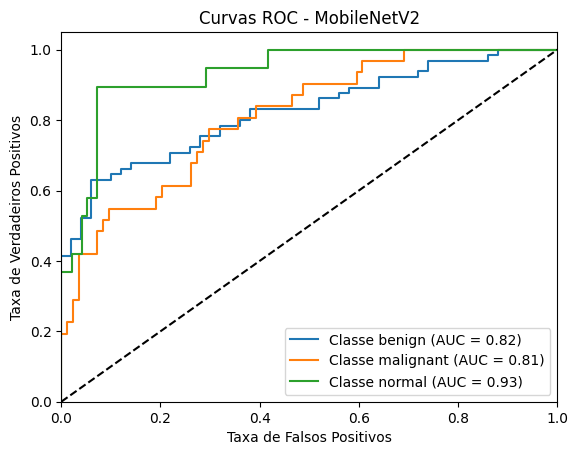

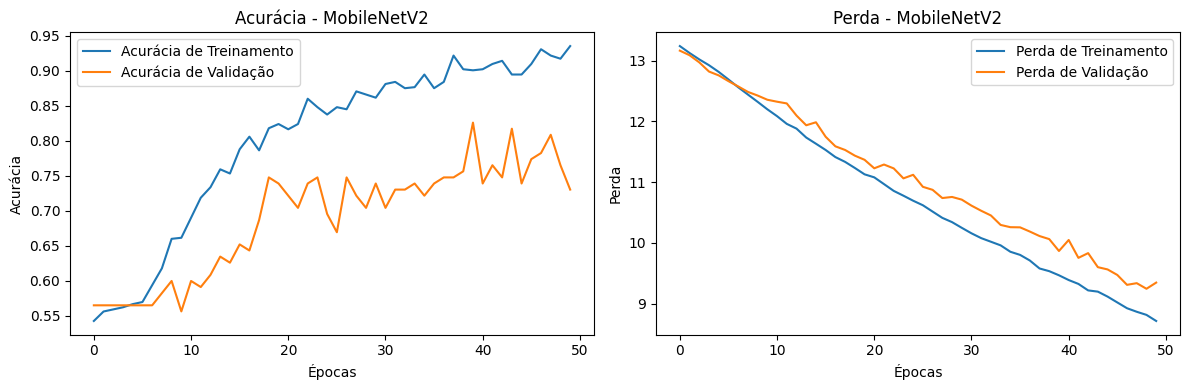

Matriz de Confusão Normalizada


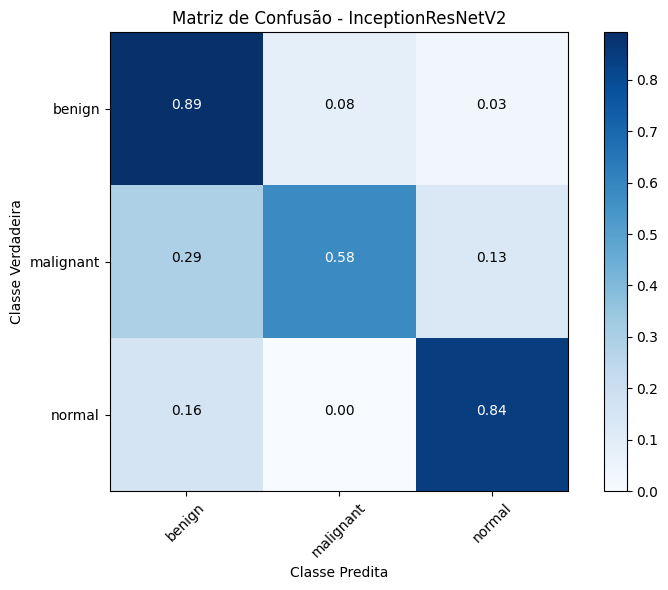

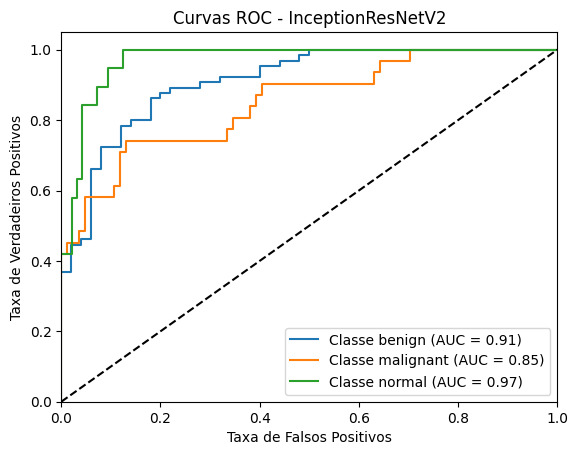

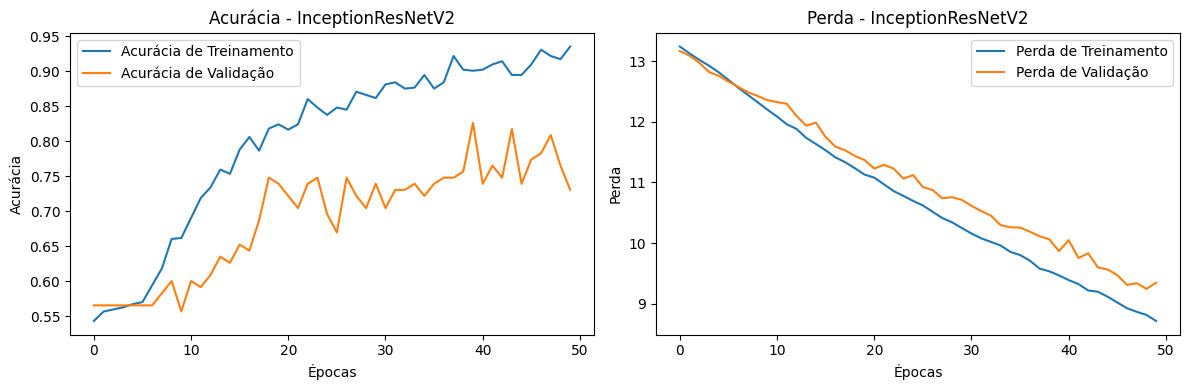

Matriz de Confusão Normalizada


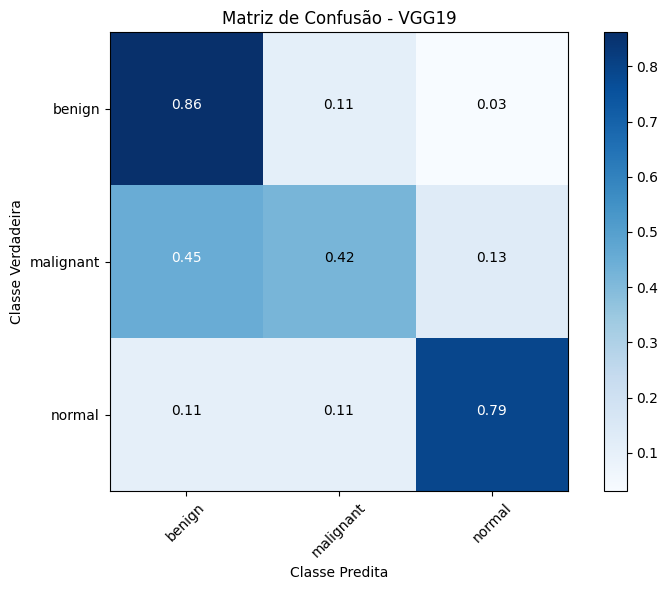

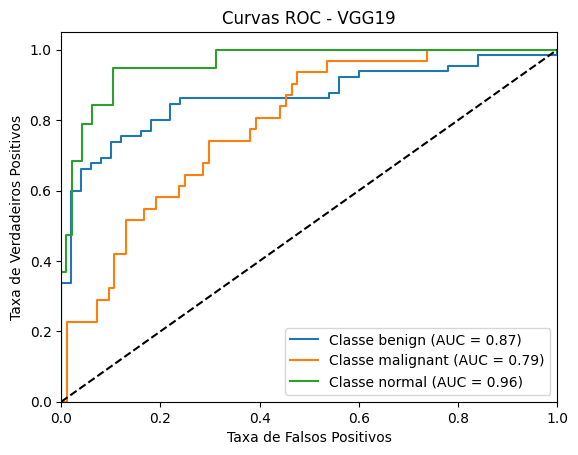

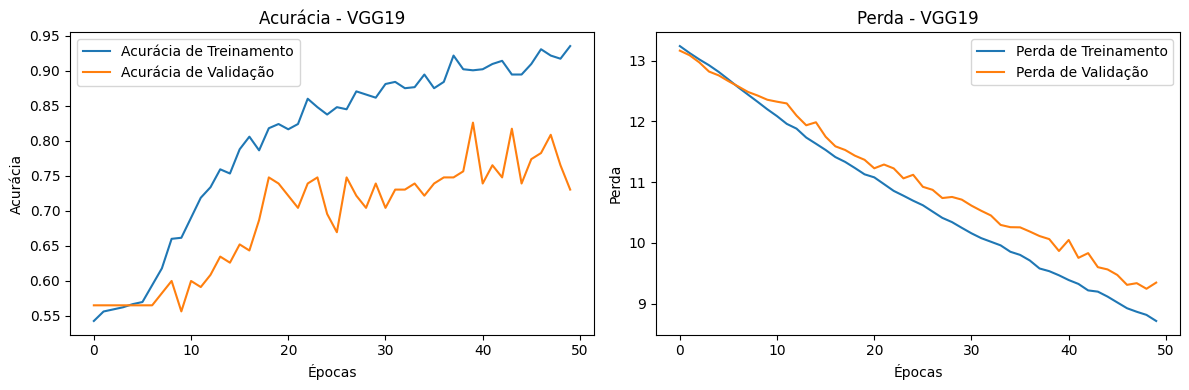

Matriz de Confusão Normalizada


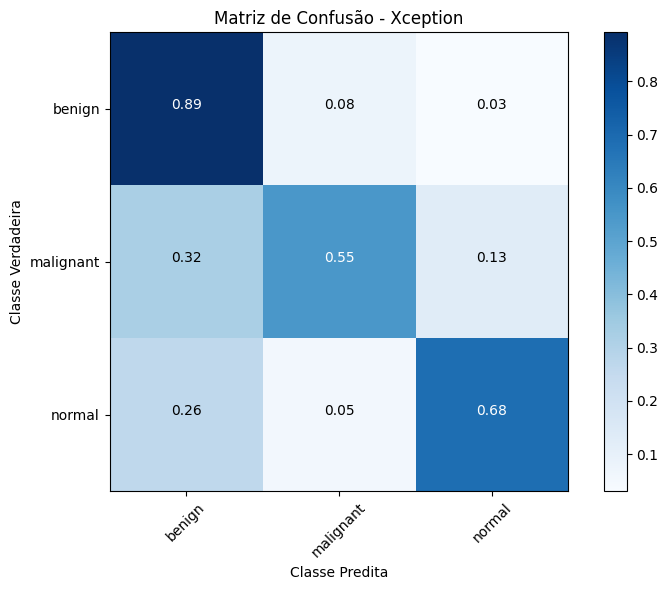

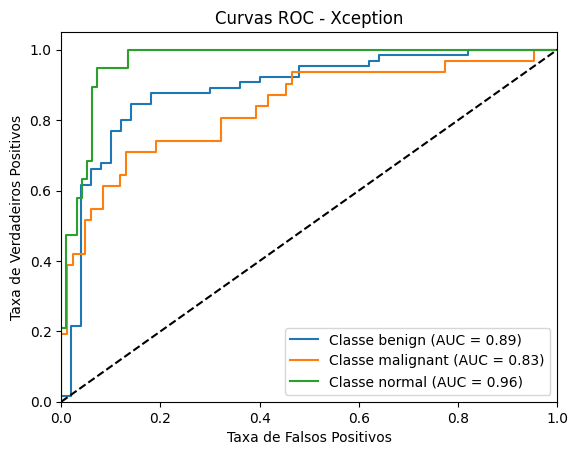

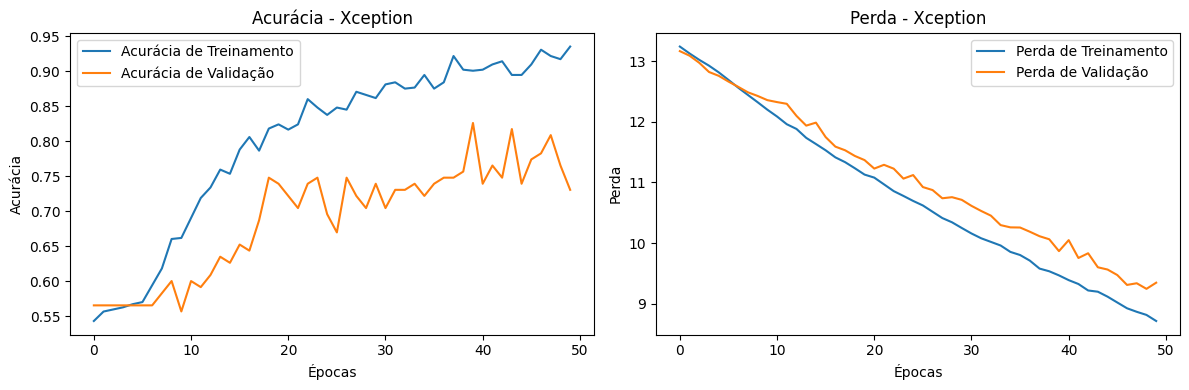

Matriz de Confusão Normalizada


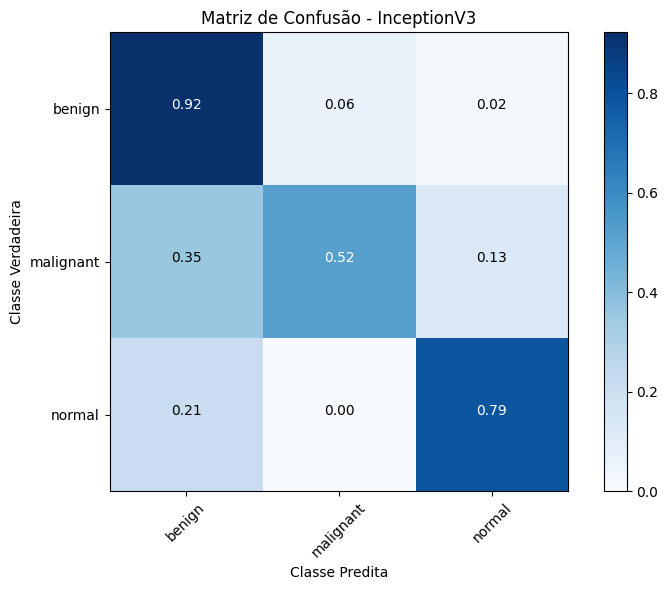

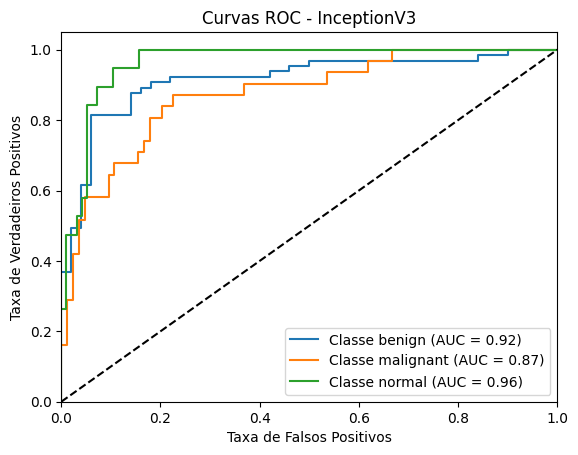

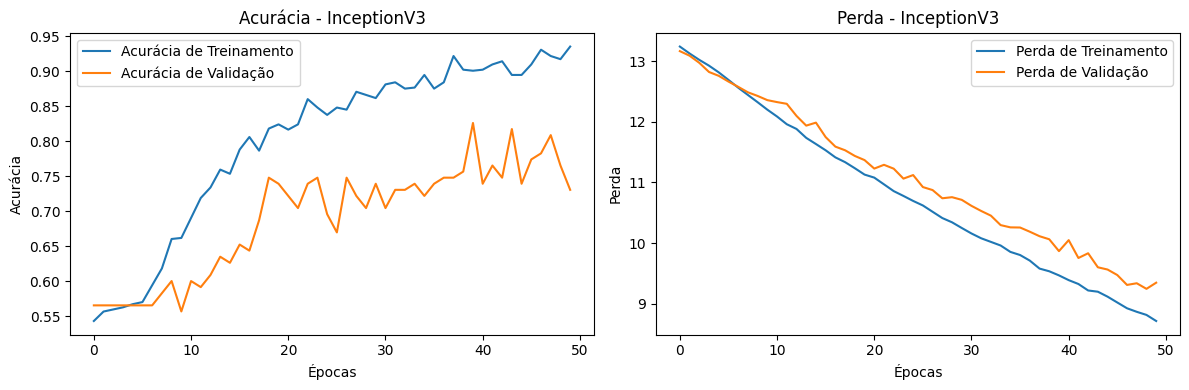

              Modelo  Acurácia Global  F1-Score Global  Tempo de Treino (s)  \
0        MobileNetV2         0.617391         0.519396           637.063909   
1  InceptionResNetV2         0.800000         0.768805          1223.923937   
2              VGG19         0.730435         0.686028                  NaN   
3           Xception         0.765217         0.718140                  NaN   
4        InceptionV3         0.791304         0.751275                  NaN   

   Tempo de Teste (s)  
0            7.724193  
1           24.861099  
2           25.307863  
3           37.077446  
4           27.582285  


In [10]:
# Criar um DataFrame para coletar as métricas globais
df_results = pd.DataFrame(columns=['Modelo', 'Acurácia Global', 'F1-Score Global', 'Tempo de Treino (s)', 'Tempo de Teste (s)'])

results_list = []

for result in results:
    model_name = result['model_name']
    report = result['classification_report']
    
    # Acurácia global
    accuracy = report['accuracy']
    # F1-Score global (calculado como a média dos F1-Scores das classes)
    f1_score = np.mean([report[label]['f1-score'] for label in class_labels])
    
    # Adicionar ao DataFrame
    results_list.append({
        'Modelo': model_name,
        'Acurácia Global': accuracy,
        'F1-Score Global': f1_score,
        'Tempo de Treino (s)': result['training_time'],
        'Tempo de Teste (s)': result['testing_time']
    })
    
    # Plotar a matriz de confusão
    plot_confusion_matrix(result['confusion_matrix'], classes=class_labels, model_name=model_name, normalize=True)
    
    # Plotar as curvas ROC
    plot_roc_curves(result['fpr'], result['tpr'], result['roc_auc'], class_labels, model_name)

    # Plotar a história de treinamento
    plot_training_history(history, model_name)

# Converter a lista de resultados em um DataFrame
df_results = pd.DataFrame(results_list)

# Exibir o DataFrame com os resultados
print(df_results)
df_results.to_csv('results.csv', index=False)

In [11]:
for result in results:
    model_name = result['model_name']
    report = result['classification_report']
    print(f"\nMétricas por classe para o modelo: {model_name}")
    for label in class_labels:
        print(f"Classe: {label}")
        print(f" - Precision: {report[label]['precision']:.4f}")
        print(f" - Recall: {report[label]['recall']:.4f}")
        print(f" - F1-score: {report[label]['f1-score']:.4f}")


Métricas por classe para o modelo: MobileNetV2
Classe: benign
 - Precision: 0.8600
 - Recall: 0.6615
 - F1-score: 0.7478
Classe: malignant
 - Precision: 0.4032
 - Recall: 0.8065
 - F1-score: 0.5376
Classe: normal
 - Precision: 1.0000
 - Recall: 0.1579
 - F1-score: 0.2727

Métricas por classe para o modelo: InceptionResNetV2
Classe: benign
 - Precision: 0.8286
 - Recall: 0.8923
 - F1-score: 0.8593
Classe: malignant
 - Precision: 0.7826
 - Recall: 0.5806
 - F1-score: 0.6667
Classe: normal
 - Precision: 0.7273
 - Recall: 0.8421
 - F1-score: 0.7805

Métricas por classe para o modelo: VGG19
Classe: benign
 - Precision: 0.7778
 - Recall: 0.8615
 - F1-score: 0.8175
Classe: malignant
 - Precision: 0.5909
 - Recall: 0.4194
 - F1-score: 0.4906
Classe: normal
 - Precision: 0.7143
 - Recall: 0.7895
 - F1-score: 0.7500

Métricas por classe para o modelo: Xception
Classe: benign
 - Precision: 0.7945
 - Recall: 0.8923
 - F1-score: 0.8406
Classe: malignant
 - Precision: 0.7391
 - Recall: 0.5484
 - F1